# Distributed Synchronous Value Iteration
***


In [1]:
import ray
import time
from copy import deepcopy
import matplotlib.pyplot as plt
from random import randint, choice
%matplotlib inline
import pickle



## FrozenLake

We will use the FrozenLake environment as the MDP environment for this experiment. This is a type of gridworld environment, whose size (number of states) can be controlled by adjusting the grid dimensions. The environment is intended to model the process of navigating a frozen lake, while avoiding falling into holes with the objective of reaching a goal location. 

Below is the code for the FrozenLake environment class, which has the following functions that will be used: 

- FrozenLake.GetSuccesors() : Take a state and an action as input, and return a list of pairs, where each pair $(s',p)$ is a successor state $s'$ with non-zero probability and $p$ is the probability of transitioning to $p$.  

- FrozenLake.GetTransitionProb() : Take a state, an action, a next state as input, and return the probability of the transition 

- FrozenLake.GetReward() : Take a state and an action as input, and return the reward of that.

The version we are using for the assignment 2 is a modified version of the environment at the following location.   
  
Source: https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py  

Execute the following cell to initialize the MDP environments. 

In [2]:
import sys
from contextlib import closing

import numpy as np
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
np.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize, precision = 2)
TransitionProb = [0.7, 0.1, 0.1, 0.1]
def generate_row(length, h_prob):
    row = np.random.choice(2, length, p=[1.0 - h_prob, h_prob])
    row = ''.join(list(map(lambda z: 'F' if z == 0 else 'H', row)))
    return row


def generate_map(shape):
    """

    :param shape: Width x Height
    :return: List of text based map
    """
    h_prob = 0.1
    grid_map = []

    for h in range(shape[1]):

        if h == 0:
            row = 'SF'
            row += generate_row(shape[0] - 2, h_prob)
        elif h == 1:
            row = 'FF'
            row += generate_row(shape[0] - 2, h_prob)

        elif h == shape[1] - 1:
            row = generate_row(shape[0] - 2, h_prob)
            row += 'FG'
        elif h == shape[1] - 2:
            row = generate_row(shape[0] - 2, h_prob)
            row += 'FF'
        else:
            row = generate_row(shape[0], h_prob)

        grid_map.append(row)
        del row

    return grid_map



MAPS = {
    
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
    "16x16": [
        "SFFFFFFFFHFFFFHF",
        "FFFFFFFFFFFFFHFF",
        "FFFHFFFFHFFFFFFF",
        "FFFFFFFFHFFFFFFF",
        "FFFFFFFFFFFFFFFF",
        "FFHHFFFFFFFHFFFH",
        "FFFFFFFFFFFFFFFF",
        "FFFFFHFFFFFFHFFF",
        "FFFFFHFFFFFFFFFH",
        "FFFFFFFHFFFFFFFF",
        "FFFFFFFFFFFFHFFF",
        "FFFFFFHFFFFFFFFF",
        "FFFFFFFFHFFFFFFF",
        "FFFFFFFFFHFFFFHF",
        "FFFFFFFFFFHFFFFF",
        "FFFHFFFFFFFFFFFG",
    ],
    
    "32x32": [
        'SFFHFFFFFFFFFFFFFFFFFFFFFFHFFFFF',
        'FFHFHHFFHFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFHFFFFFFFFHFFHFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFHFHHFHFHFFFFFHFFFH',
        'FFFFHFFFFFFFFFFFFFFFHFHFFFFFFFHF',
        'FFFFFHFFFFFFFFFFHFFFFFFFFFFHFFFF',
        'FFHHFFFFHFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFHFFFFFFFFFFHFFFHFHFFFFFFFFHFF',
        'FFFFHFFFFFFHFFFFHFHFFFFFFFFFFFFH',
        'FFFFHHFHFFFFHFFFFFFFFFFFFFFFFFFF',
        'FHFFFFFFFFFFHFFFFFFFFFFFHHFFFHFH',
        'FFFHFFFHFFFFFFFFFFFFFFFFFFFFHFFF',
        'FFFHFHFFFFFFFFHFFFFFFFFFFFFHFFHF',
        'FFFFFFFFFFFFFFFFHFFFFFFFHFFFFFFF',
        'FFFFFFHFFFFFFFFHHFFFFFFFHFFFFFFF',
        'FFHFFFFFFFFFHFFFFFFFFFFHFFFFFFFF',
        'FFFHFFFFFFFFFHFFFFHFFFFFFHFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFFFHFFFFF',
        'FFFFFFFFHFFFFFFFHFFFFFFFFFFFFFFH',
        'FFHFFFFFFFFFFFFFFFHFFFFFFFFFFFFF',
        'FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFHFFFFHFFFFFFFHFFF',
        'FFHFFFFHFFFFFFFFFHFFFFFFFFFFFHFH',
        'FFFFFFFFFFHFFFFHFFFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFFFHHFFHHHFFFHFFFF',
        'FFFFFFFFFFFFFFHFFFFHFFFFFFFHFFFF',
        'FFFFFFFHFFFFFFFFFFFFFFFFFFFFFFFF',
        'FFFFFHFFFFFFFFFFFFFFFFHFFHFFFFFF',
        'FFFFFFFHFFFFFFFFFHFFFFFFFFFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF',
        'FFFFFFFFFFFFFFFFFFFFFFFFHFFFFFFF',
        'FFFFFFFFFFFFFFFHFFFFFFFFHFFFFFFG',
    ]
}


def generate_random_map(size=8, p=0.8):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False

    # BFS to check that it's a valid path.
    def is_valid(arr, r=0, c=0):
        if arr[r][c] == 'G':
            return True

        tmp = arr[r][c]
        arr[r][c] = "#"

        # Recursively check in all four directions.
        directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        for x, y in directions:
            r_new = r + x
            c_new = c + y
            if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                continue

            if arr[r_new][c_new] not in '#H':
                if is_valid(arr, r_new, c_new):
                    arr[r][c] = tmp
                    return True

        arr[r][c] = tmp
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]


class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4",is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        rew_hole = -1000
        rew_goal = 1000
        rew_step = -1
        
        P = {s : {a : [] for a in range(nA)} for s in range(nS)}
        self.TransitProb = np.zeros((nA, nS + 1, nS + 1))
        self.TransitReward = np.zeros((nS + 1, nA))
        
        def to_s(row, col):
            return row*ncol + col
        
        def inc(row, col, a):
            if a == LEFT:
                col = max(col-1,0)
            elif a == DOWN:
                row = min(row+1,nrow-1)
            elif a == RIGHT:
                col = min(col+1,ncol-1)
            elif a == UP:
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'H':
                        li.append((1.0, s, 0, True))
                        self.TransitProb[a, s, nS] = 1.0
                        self.TransitReward[s, a] = rew_hole
                    elif letter in b'G':
                        li.append((1.0, s, 0, True))
                        self.TransitProb[a, s, nS] = 1.0
                        self.TransitReward[s, a] = rew_goal
                    else:
                        if is_slippery:
                            #for b in [(a-1)%4, a, (a+1)%4]:
                            for b, p in zip([a, (a+1)%4, (a+2)%4, (a+3)%4], TransitionProb):
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                #rew = float(newletter == b'G')
                                #li.append((1.0/10.0, newstate, rew, done))
                                if newletter == b'G':
                                    rew = rew_goal
                                elif newletter == b'H':
                                    rew = rew_hole
                                else:
                                    rew = rew_step
                                li.append((p, newstate, rew, done))
                                self.TransitProb[a, s, newstate] += p
                                self.TransitReward[s, a] = rew_step
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()
    
    def GetSuccessors(self, s, a):
        next_states = np.nonzero(self.TransitProb[a, s, :])
        probs = self.TransitProb[a, s, next_states]
        return [(s,p) for s,p in zip(next_states[0], probs[0])]
    
    def GetTransitionProb(self, s, a, ns):
        return self.TransitProb[a, s, ns]
    
    def GetReward(self, s, a):
        return self.TransitReward[s, a]
    
    def GetStateSpace(self):
        return self.TransitProb.shape[1]
    
    def GetActionSpace(self):
        return self.TransitProb.shape[0]

***
## Initializations

Run the following cell to initilize maps of different sizes.

In [3]:
map_8 = (MAPS["8x8"], 8)
map_16 = (MAPS["16x16"], 16)
map_32 = (MAPS["32x32"], 32)
map_50 = (generate_map((50,50)), 50)
map_110 = (generate_map((110,110)), 110)

MAP = map_8
map_size = MAP[1]
run_time = {}

## Policy Evaluation 

In [4]:
def evaluate_policy(env, policy, trials = 1000):
    total_reward = 0
    for _ in range(trials):
        env.reset()
        done = False
        observation, reward, done, info = env.step(policy[0])
        total_reward += reward
        while not done:
            observation, reward, done, info = env.step(policy[observation])
            total_reward += reward
    return total_reward / trials

def evaluate_policy_discounted(env, policy, discount_factor, trials = 1000):
    total_reward = 0
    for _ in range(trials):
        env.reset()
        done = False
        observation, reward, done, info = env.step(policy[0])
        total_reward += reward
        power = 0
        while not done:
            observation, reward, done, info = env.step(policy[observation])
            total_reward += pow(discount_factor, power) * reward
            power += 1
    return total_reward / trials

## Helper Function
This function shows the policy and state values and saves them to disk.

In [5]:
def print_results(v, pi, map_size, env, beta, name):
    v_np, pi_np  = np.array(v), np.array(pi)
    print("\nState Value:\n")
    print(np.array(v_np[:-1]).reshape((map_size,map_size)))
    print("\nPolicy:\n")
    print(np.array(pi_np[:-1]).reshape((map_size,map_size)))
    print("\nAverage reward: {}\n".format(evaluate_policy(env, pi)))
    print("Avereage discounted reward: {}\n".format(evaluate_policy_discounted(env, pi, discount_factor = beta)))
    print("State Value image view:\n")
    plt.imshow(np.array(v_np[:-1]).reshape((map_size,map_size)))
    
    pickle.dump(v, open(name + "_" + str(map_size) + "_v.pkl", "wb"))
    pickle.dump(pi, open(name + "_" + str(map_size) + "_pi.pkl", "wb"))

***
## Initialize Ray

Now we are going to use Ray to develop distributed versions of the above value iteration algorithm. The first step of course is to initialize Ray.

In [6]:
ray.shutdown()
ray.init(include_webui = False, ignore_reinit_error=True, redis_max_memory=100000000, object_store_memory=1000000000)

2021-06-21 00:04:31,756	INFO resource_spec.py:212 -- Starting Ray with 186.62 GiB memory available for workers and up to 0.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '10.9.1.6',
 'redis_address': '10.9.1.6:17461',
 'object_store_address': '/tmp/ray/session_2021-06-21_00-04-31_754119_15735/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-21_00-04-31_754119_15735/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-06-21_00-04-31_754119_15735'}

In [11]:
@ray.remote
class VI_server(object):
    
    def __init__(self, size):
        self.v_current = [0] * size
        self.pi = [0] * size
        self.v_new = [0] * size
    
    def get_value_and_policy(self):
        return self.v_current, self.pi
    
    def update(self, update_index_part, update_v_part, update_pi_part):
        for i, update_index in enumerate(update_index_part):
            self.v_new[update_index] = update_v_part[i]
            self.pi[update_index] = update_pi_part[i]
    
    def get_error_and_update(self):
        max_error = 0
        for i in range(len(self.v_current)):
            error = abs(self.v_new[i] - self.v_current[i])
            if error > max_error:
                max_error = error
            self.v_current[i] = self.v_new[i]
        return max_error
    
@ray.remote
def VI_worker(VI_server, data, start_state, end_state):
    env, workers_num, beta, epsilon = data
    A = env.GetActionSpace()
    S = env.GetStateSpace()

    successors = {}
    for state in range(start_state, end_state):
        for action in range(A):
            successors[(state, action)] = env.GetSuccessors(state, action)

    #get shared variable
    partofv, _ = ray.get(VI_server.get_value_and_policy.remote())

    #bellman backup
    update_v_part = [0] * (end_state - start_state)
    update_pi_part = [0] * (end_state - start_state)
    update_index_part = []
    for index in range(start_state, end_state):
        update_index_part.append(index)
#         update_index_list = list(range(start_state, end_state))

    for index, state in enumerate(update_index_part):
        max_v = float('-inf')
        max_a = 0
        for action in range(A):
            new_v = 0
            for n_state, prob in successors[(state, action)]:
                new_v += beta * prob * partofv[n_state]
            new_v += env.GetReward(state, action)
            if new_v > max_v:
                max_v = new_v
                max_a = action
        update_v_part[index] = max_v
        update_pi_part[index] = max_a

    VI_server.update.remote(update_index_part, update_v_part, update_pi_part)
                    
                    
def sync_value_iteration_distributed(env, beta = 0.999, epsilon = 0.01, workers_num = 4, stop_steps = 2000):
    S = env.GetStateSpace()
    VI_Server = VI_server.remote(S)
    workers_list = []
    data_id = ray.put((env, workers_num, beta, epsilon))

    # initial start states and end states list for workers 
    start_state_list = [0] * workers_num
    end_state_list = [0] * workers_num
    
    # size of states for each worker
    size = S // workers_num
    
    # fill lists
    for i in range(workers_num):
        if (i + 1) * size < S: 
            # not the last worker
            start_state_list[i] = i * size
            end_state_list[i] = (i + 1) * size
        else:  
            # the last worker
            start_state_list[i] = i * size
            end_state_list[i] = S
            
    error = float('inf')
    while error > epsilon:
        w_ids = []
        for i in range(workers_num):
            w_ids.append(VI_worker.remote(VI_Server, data_id, start_state_list[i], end_state_list[i]))
    
        ray.wait(w_ids, num_returns = 1)  
        error = ray.get(VI_Server.get_error_and_update.remote())

    v, pi = ray.get(VI_Server.get_value_and_policy.remote())
    
    return v, pi

Run the following code to see the running time, and store the policy and state values to disk.

Game Map:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
time: 1.7620351314544678

State Value:

[[  363.5    365.91   369.38   376.73   400.45   411.84   418.7    422.15]
 [  360.23   357.71   335.11   231.84   358.44   389.37   415.63   424.67]
 [  353.54   333.98   189.28 -1000.     173.63   227.87   389.72   428.36]
 [  339.81   306.39   224.98   -42.37    11.12 -1000.     269.05   436.45]
 [  290.57   139.43   -29.55 -1000.     -51.75    81.41   258.29   463.58]
 [  110.03 -1000.   -1000.    -309.32   -88.99    68.62 -1000.     498.87]
 [  -32.51 -1000.    -463.44  -463.41 -1000.     243.49 -1000.     720.18]
 [  -53.11  -187.7   -309.37 -1000.     262.9    625.53   734.24  1000.  ]]

Policy:

[[2 2 2 2 2 2 2 1]
 [3 3 3 3 3 2 2 1]
 [3 3 3 0 3 2 2 1]
 [3 0 0 0 3 0 2 1]
 [3 3 3 0 2 2 2 1]
 [3 0 0 2 2 1 0 1]
 [3 0 1 3 0 1 0 1]
 [3 0 0 0 2 2 2 0]]

Average reward: 399.519

Avereage discounted reward: 346.9153753922206

State Value image view:



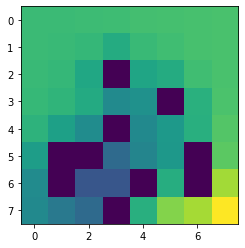

In [12]:
beta = 0.999
env = FrozenLakeEnv(desc = MAP[0], is_slippery = True)
print("Game Map:")
env.render()

start_time = time.time()
v, pi = sync_value_iteration_distributed(env, beta = beta, workers_num = 4)
v_np, pi_np  = np.array(v), np.array(pi)
end_time = time.time()
run_time['Sync distributed'] = end_time - start_time
print("time:", run_time['Sync distributed'])
print_results(v, pi, map_size, env, beta, 'dist_vi')